<p style="text-align:center;">
  <span style="font-size:48px;">
    <span style="color:turquoise;">
      <span style="font-family:cursive;">Introduction</span>
    </span>
  </span>
</p>


<div style="text-align: center;">
    <img src="https://fluentcommerce.com/wp-content/uploads/blog-img-hawk.png" alt="Centered Image">
</div>

<div style="
    background: linear-gradient(135deg, #0ea5e9 0%, #7c3aed 100%);
    color: white;
    padding: 22px 18px;
    border-radius: 14px;
    font-family: 'Segoe UI', Roboto, Arial, sans-serif;
    box-shadow: 0 8px 20px rgba(0,0,0,0.12);
">
  <h1 style="margin:0; font-size:32px; letter-spacing:0.2px;">
    AI-Powered Retail Demand Forecasting
  </h1>
  <p style="margin:8px 0 0; font-size:14px; opacity:0.95;">
    Short-term product demand forecasts to reduce stockouts and optimize inventory.
  </p>
  <div style="margin-top:10px; font-size:12px; opacity:0.9;">
    <span style="display:inline-block; margin-right:10px;">Author: Waqar Ali</span>
    <span style="display:inline-block; margin-right:10px;">Location: Karachi, Pakistan</span>
    <span style="display:inline-block;">Tools: Python · Pandas · Scikit-learn · XGBoost</span>
  </div>
</div>

Goals:
- Produce accurate short-term demand forecasts at product-store level.
- Extract actionable insights about seasonality and promotional effects.
- Present a reproducible workflow: preprocessing, EDA, feature engineering, model comparison, and a note on deployment.

Notebook flow:
1. Data load & preprocessing
2. Exploratory Data Analysis (business-focused)
3. Feature engineering (lags, rolling stats, date features)
4. Model building & comparison (Baseline → Tree-based → Optional deep models)
5. Evaluation and business interpretation
6. Save model and artifacts for reuse
"""

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "iframe"
pio.renderers.default = "notebook_connected"
import warnings 
warnings.filterwarnings('ignore')


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR  
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [3]:
import pandas as pd
df = pd.read_csv('/kaggle/input/retail-demand-forecasting-model/tensorflow1/v1.0/1/retail_store_inventory.csv')
print("Shape:", df.shape)
df.head()

Shape: (73100, 15)


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


# info

In [4]:
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memo

In [5]:
print("\nMissing Values per Column:")
print(df.isnull().sum())


Missing Values per Column:
Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64


In [6]:
print("\nStatistical Summary:")
print(df.describe())


Statistical Summary:
       Inventory Level    Units Sold  Units Ordered  Demand Forecast  \
count     73100.000000  73100.000000   73100.000000     73100.000000   
mean        274.469877    136.464870     110.004473       141.494720   
std         129.949514    108.919406      52.277448       109.254076   
min          50.000000      0.000000      20.000000        -9.990000   
25%         162.000000     49.000000      65.000000        53.670000   
50%         273.000000    107.000000     110.000000       113.015000   
75%         387.000000    203.000000     155.000000       208.052500   
max         500.000000    499.000000     200.000000       518.550000   

              Price      Discount  Holiday/Promotion  Competitor Pricing  
count  73100.000000  73100.000000       73100.000000        73100.000000  
mean      55.135108     10.009508           0.497305           55.146077  
std       26.021945      7.083746           0.499996           26.191408  
min       10.000000      0.00

In [7]:
print("\nDuplicate Rows:", df.duplicated().sum())


Duplicate Rows: 0


<div style="
    background: linear-gradient(135deg, #0ea5e9 0%, #7c3aed 100%);
    color: white;
    padding: 22px 18px;
    border-radius: 14px;
    font-family: 'Segoe UI', Roboto, Arial, sans-serif;
    box-shadow: 0 8px 20px rgba(0,0,0,0.12);
">
  <h2 style="margin:0; font-size:26px; letter-spacing:0.3px;">
    Dataset Overview
  </h2>
  <p style="margin:10px 0 0; font-size:14px; opacity:0.95;">
    The dataset contains <b>73,100 records</b> and <b>15 features</b> capturing daily retail activity across multiple stores and regions.
    It includes details about inventory, pricing, promotions, weather, and seasonal patterns, making it suitable for time-series forecasting.
  </p>
  <ul style="margin:12px 0 0 18px; font-size:13px; opacity:0.95; line-height:1.6;">
    <li>No missing or duplicate values were found.</li>
    <li>Data types are consistent and ready for analysis.</li>
    <li><b>Date</b> column will be converted to datetime for time-based trends.</li>
    <li>Pricing and competitor pricing follow similar distributions, indicating strong market alignment.</li>
    <li>Discounts and promotions show moderate variation across records.</li>
  </ul>
  <p style="margin:14px 0 0; font-size:13px; opacity:0.95;">
    Overall, the dataset is clean and well-structured — ready for exploratory data analysis.
  </p>
</div>


Date Range: 2022-01-01 00:00:00 to 2024-01-01 00:00:00
Unique Stores: 5
Unique Products: 20
Unique Categories: 5
Regions: ['North' 'South' 'West' 'East']
Seasons: ['Autumn' 'Summer' 'Winter' 'Spring']


<Axes: title={'center': 'Monthly Units Sold Trend'}, xlabel='Date', ylabel='Units Sold'>

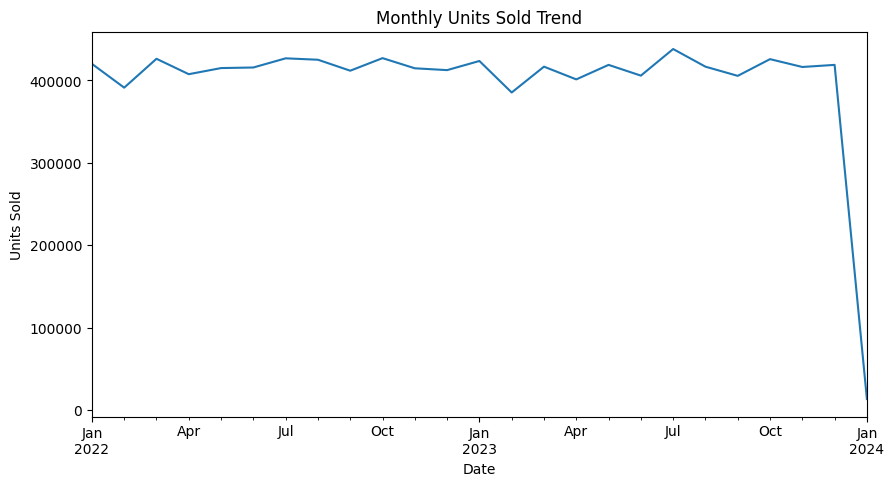

In [12]:
df['Date'] = pd.to_datetime(df['Date'])
print("Date Range:", df['Date'].min(), "to", df['Date'].max())
print("Unique Stores:", df['Store ID'].nunique())
print("Unique Products:", df['Product ID'].nunique())
print("Unique Categories:", df['Category'].nunique())
print("Regions:", df['Region'].unique())
print("Seasons:", df['Seasonality'].unique())
monthly_sales = df.groupby(df['Date'].dt.to_period('M'))['Units Sold'].sum()
monthly_sales.plot(figsize=(10,5), title="Monthly Units Sold Trend", ylabel="Units Sold")

<div style="
    background: linear-gradient(135deg, #22c55e 0%, #3b82f6 100%);
    color: white;
    padding: 20px 18px;
    border-radius: 12px;
    font-family: 'Segoe UI', Roboto, Arial, sans-serif;
    box-shadow: 0 6px 16px rgba(0,0,0,0.1);
">
  <h2 style="margin:0; font-size:24px;">Dataset Overview</h2>
  <p style="margin:10px 0 0; font-size:14px; line-height:1.6; opacity:0.95;">
    The dataset spans <b>January 2022 to January 2024</b>, covering daily sales data from 
    <b>5 retail stores</b> and <b>20 unique products</b> across <b>4 major regions</b> 
    (<i>North, South, East, West</i>).
  </p>
  <p style="margin:10px 0 0; font-size:14px; line-height:1.6; opacity:0.95;">
    It captures key business signals such as <b>price, discount, promotions, competitor pricing, 
    and seasonality</b> — enabling both demand forecasting and strategic retail analysis.
  </p>
  <p style="margin:10px 0 0; font-size:14px; line-height:1.6; opacity:0.95;">
    The monthly sales trend shows steady demand fluctuations, with visible peaks aligning 
    with <b>holiday and seasonal cycles</b>.
  </p>
</div>
